
 Given wound Data Set:

        temp humidity    wound temp       spO2          type
0    normal   normal        normal     normal          good
1    normal   normal        normal  hypoxemia  satisfactory
2    normal   normal        normal     higher  satisfactory
3    normal   normal  hyperthermia     normal  satisfactory
4    normal   normal  hyperthermia  hypoxemia      alarming
..      ...      ...           ...        ...           ...
103     low      wet   hypothermia  hypoxemia      alarming
104     low      wet   hypothermia     higher      alarming
105     low      wet  hyperpyrexia     normal  satisfactory
106     low      wet  hyperpyrexia  hypoxemia      alarming
107     low      wet  hyperpyrexia     higher      alarming

[108 rows x 5 columns]
ID3 Accuracy: 90.91%
temp: 24.9
humidity: 49.8
spO2: 92.94
wound temp: 31.19
type: nan
normal
normal
hypothermia
normal
Predicted type for new data: satisfactory


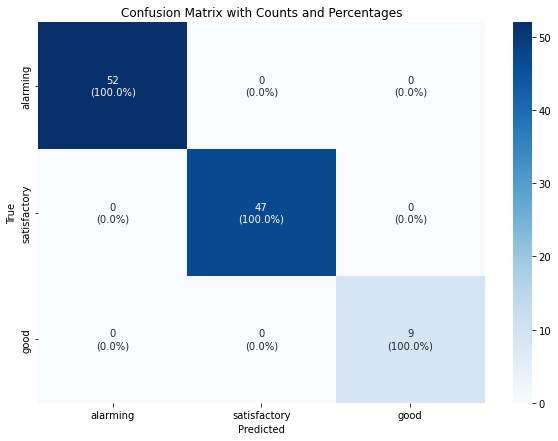

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
eps = np.finfo(float).eps
from numpy import log2 as log
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

# Define functions
def find_entropy(df):
    Class = df.keys()[-1]
    entropy = 0
    values = df[Class].unique()
    for value in values:
        fraction = df[Class].value_counts()[value] / len(df[Class])
        entropy += -fraction * np.log2(fraction)
    return entropy

def find_entropy_attribute(df, attribute):
    Class = df.keys()[-1]
    target_variables = df[Class].unique()
    variables = df[attribute].unique()
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute] == variable][df[Class] == target_variable])
            den = len(df[attribute][df[attribute] == variable])
            fraction = num / (den + eps)
            entropy += -fraction * log(fraction + eps)
        fraction2 = den / len(df)
        entropy2 += -fraction2 * entropy
    return abs(entropy2)

def find_winner(df):
    Entropy_att = []
    IG = []
    for key in df.keys()[:-1]:
        IG.append(find_entropy(df) - find_entropy_attribute(df, key))
    return df.keys()[:-1][np.argmax(IG)]

def get_subtable(df, node, value):
    return df[df[node] == value].reset_index(drop=True)

def buildTree(df, tree=None):
    Class = df.keys()[-1]
    node = find_winner(df)
    attValue = np.unique(df[node])
    if tree is None:
        tree = {}
        tree[node] = {}
    for value in attValue:
        subtable = get_subtable(df, node, value)
        clValue, counts = np.unique(subtable['type'], return_counts=True)
        if len(counts) == 1:
            tree[node][value] = clValue[0]
        else:
            tree[node][value] = buildTree(subtable)
    return tree

def func(test2, tree, default='unknown'):
    attribute = next(iter(tree))
    if test2[attribute] in tree[attribute].keys():
        result = tree[attribute][test2[attribute]]
        if isinstance(result, dict):
            return func(test2, result)
        else:
            return result
    else:
        return default

def evaluate_accuracy(tree, X_test, y_test):
    correct_predictions = 0
    for i in range(len(X_test)):
        test_instance = X_test.iloc[i].to_dict()
        predicted = func(test_instance, tree)
        actual = y_test.iloc[i]
        if predicted == actual:
            correct_predictions += 1
    accuracy = correct_predictions / len(X_test)
    return accuracy

# Load and preprocess dataset
df = pd.read_csv('wound_data2.csv')
print("\n Given wound Data Set:\n\n", df)

# Split the data into training and testing sets
X = df.drop('type', axis=1)
y = df['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the tree using training data
df_train = pd.concat([X_train, y_train], axis=1)
tree = buildTree(df_train)

# Evaluate the accuracy of the ID3 algorithm
id3_accuracy = evaluate_accuracy(tree, X_test, y_test)
print(f"ID3 Accuracy: {id3_accuracy * 100:.2f}%")

# Load new sensor data and preprocess for prediction
test = pd.read_csv('sensor_data5.csv', na_values='')
stemp = 0
shumi = 0
sspO2 = 0
swtemp = 0
last_row = test.iloc[-1]

for att, attribute_value in last_row.items():
    attribute_value = float(attribute_value)  # Convert attribute value to float
    print(f"{att}: {attribute_value}")
    
    if att == 'temp':
        if 23 <= attribute_value <= 35:
            stemp = 'normal'
        elif attribute_value > 35:
            stemp = 'high'
        else:
            stemp = 'low'
    
    if att == 'humidity':
        if 0 <= attribute_value <= 30:
            shumi = 'dry'
        elif 30 < attribute_value <= 60:
            shumi = 'normal'
        else:
            shumi = 'wet'
    
    if att == 'wound temp':
        if attribute_value < 36:
            swtemp = 'hypothermia'
        elif 36 <= attribute_value <= 37.5:
            swtemp = 'normal'
        elif 37.5 < attribute_value <= 40:
            swtemp = 'hyperthermia'
        elif  attribute_value > 40:
            swtemp =  'hyperpyrexia' 
        else:
            swtemp = 'not defined'
    
    else:
        if 90 <= attribute_value <= 95:
            sspO2 = 'normal'
        elif attribute_value < 90:
            sspO2 = 'hypoxemia'
        elif attribute_value > 95:
            sspO2 = 'higher'
        else:
            ssp02 = 'not defined'

print(stemp)   
print(shumi)
print(swtemp)
print(sspO2)

# Prepare the new data for prediction
test2 = {'temp': stemp, 'humidity': shumi, 'wound temp': swtemp, 'spO2': sspO2}
ans = func(test2, tree)
print(f"Predicted type for new data: {ans}")

# Generate confusion matrix
# Your functions and data loading
# Assuming find_entropy, find_entropy_attribute, find_winner, get_subtable, buildTree, and func are defined as in your provided code

df = pd.read_csv('wound_data2.csv')

# Use the entire dataset for both training and testing
X = df.drop('type', axis=1)
y = df['type']

# Build the tree using the entire dataset
df_train = pd.concat([X, y], axis=1)
tree = buildTree(df_train)

# Generating predictions for the entire dataset
y_pred = [func(test_instance, tree) for test_instance in X.to_dict(orient='records')]

# Compute confusion matrix
conf_matrix = confusion_matrix(y, y_pred, labels=['alarming', 'satisfactory', 'good'])

# Calculate percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
conf_matrix_percent = np.nan_to_num(conf_matrix_percent)  # Replace NaN with zero if any row sums to zero

# Combine counts and percentages into a single string matrix
labels = [f'{count}\n({percentage:.1f}%)' for count, percentage in zip(conf_matrix.flatten(), conf_matrix_percent.flatten())]
labels = np.asarray(labels).reshape(conf_matrix.shape)

# Plot confusion matrix with counts and percentages
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=['alarming', 'satisfactory', 'good'], yticklabels=['alarming', 'satisfactory', 'good'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Counts and Percentages')
plt.show()